# Redes Neurais

Esse documento traz uma implementação de uma classe para criação de redes neurais artificiais. Essa implementação será usada nos trabalhos exercícios da disciplina.

## Preliminares

* $J = \frac{1}{2n} \sum_{i = 1}^n ||a^L - y||^2$

* $W^l_{N_{l},N_{l-1}}$ Matriz de pesos que liga a camada l com a camada l-1.

* $z^l = W^la^{l-1}+b^l$

* $a^l = f(z^l)$

### Objetivo

Queremos encontrar os pesos que minimizem J. Para isso, pela regras da cadeia, temos o seguinte:

$$\frac{\partial J}{\partial W^L} = \frac{\partial J}{\partial a^L}\frac{\partial a^L}{\partial z^L}\frac{\partial z^L}{\partial W^L}$$

* $\frac{\partial J}{\partial a^L} = (a^L-y)$

* $\frac{\partial a^L}{\partial z^L} = diag(f'(z^l))$

O ultimo termo é um pouco mais complicado, visto que seu resultado é um tensor. Mas veja que:

$$\frac{\partial z^L}{\omega^L_{i,j}} = a_j^{L-1}$$

Alé disso defina:
$$\delta^l :=  \frac{\partial J}{\partial z^l}$$

Portatanto:

$$\frac{\partial J}{\partial W^L} = [(a^L-y)\odot f'(z^L)](a^{L-1})^T =\delta^L (a^{L-1})^T $$

Analogamente:

$$\frac{\partial J}{\partial b^L} = (a^L-y)\odot f'(z^L) =\delta^L$$


Agora precisamos de uma forma de escrever $\delta^l$ em função de $\delta^{l+1}$ pois, como conhecemos $\delta$ da última camada, podemos calcular todos. (backpropagation)

$$\delta^l = \frac{\partial J}{\partial z^l}$$
Mas pela regra da cadeia temos que:

$$\delta^l = \frac{\partial J}{\partial z^l} = (\frac{\partial z^{l+1}}{\partial z^l})^T \frac{\partial J}{\partial z^{l+1}} = (W^{l+1})^T\delta^{l+1} \odot f'(z^l)$$

### Implementação da Rede

In [13]:
import numpy as np

# Funções de ativação e suas derivadas
def tanh(z):
   
    return np.tanh(z)

def tanh_deriv(z):
   
    return 1.0 - np.tanh(z)**2

class NeuralNetwork(object):
    
    def __init__(self, sizes):
    
        self.num_layers = len(sizes)
        self.sizes = sizes
        # Biases são inicializados para todas as camadas, exceto a de entrada
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]] 
        # Pesos conectam camadas adjacentes
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
    
    def feedforward(self, x):
        
        activation = x
        # Aplica a ativação tanh para todas as camadas, exceto a última
        for w, b in zip(self.weights[:-1], self.biases[:-1]):
            activation = tanh(np.dot(w, activation) + b)
        
        # A última camada é linear (sem função de ativação)
        output = np.dot(self.weights[-1], activation) + self.biases[-1]
        return output

    def back_prop(self, x, y):
        
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        
      
        # Armazena todas as ativações e vetores 'z' (soma ponderada + bias)
        activation = x
        activations = [x]  # Lista para armazenar as ativações, camada por camada
        zs = []            # Lista para armazenar os vetores z, camada por camada
        
        # Propaga para as camadas ocultas com tanh
        for w, b in zip(self.weights[:-1], self.biases[:-1]):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = tanh(z)
            activations.append(activation)
        
        # Propaga para a última camada (linear)
        z = np.dot(self.weights[-1], activation) + self.biases[-1]
        zs.append(z)
        activations.append(z)  # A "ativação" final é o próprio z
        
        
        # Erro na camada de saída (custo quadrático com saída linear)
        delta = (activations[-1] - y)
        grad_b[-1] = delta
        grad_w[-1] = np.dot(delta, activations[-2].T)
        
        # Propaga o erro para as camadas anteriores
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = tanh_deriv(z) # Derivada da função de ativação
            delta = np.dot(self.weights[-l+1].T, delta) * sp
            grad_b[-l] = delta
            grad_w[-l] = np.dot(delta, activations[-l-1].T)
        
        return grad_b, grad_w

    def train(self, x_data, y_data, epochs, eta,print_cost=True):
        
        num_samples = x_data.shape[0]
        for epoch in range(epochs):
            error_epoch = 0
            
            # Aleatoriza a ordem das amostras a cada época
            index = np.random.permutation(num_samples)
            
            for i in index:
                
                
                x_sample = x_data[i]
                y_sample = y_data[i]

                grad_b, grad_w = self.back_prop(x_sample, y_sample)
                
                # Atualiza os pesos e biases
                self.weights = [w - (eta * gw) for w, gw in zip(self.weights, grad_w)]
                self.biases = [b - (eta * gb) for b, gb in zip(self.biases, grad_b)]
                
                # Calcula o erro para a amostra
                error_epoch += np.linalg.norm(self.feedforward(x_sample) - y_sample)**2
            if print_cost:
            
                    print(f"Epoch {epoch+1}, MSE: {error_epoch / num_samples}")



### Dados XOR

Por natureza são dados não linearmente separáveis, portanto nenhuma transformação linear possibilita que um hiper-plano os separem. Nesse sentido, faz-se necessário introduzir funções não lineares no modelo. 

**É daí que vem a força das RNA.**

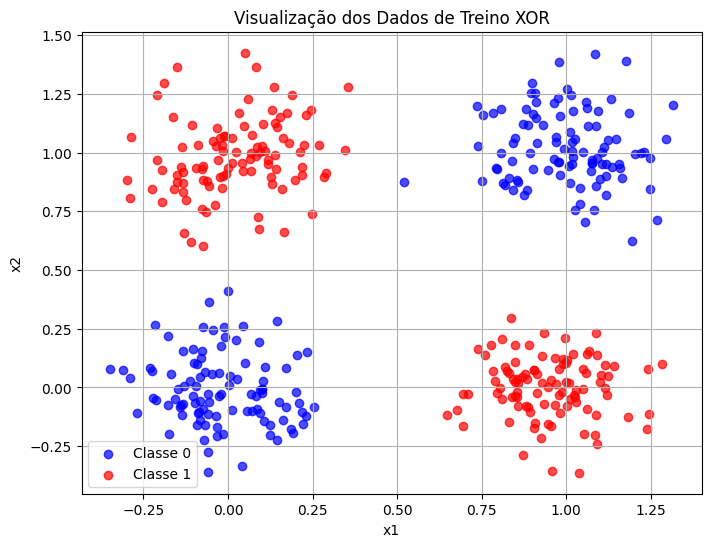

In [14]:
import matplotlib.pyplot as plt

def create_xor_data(num_samples_per_class, noise=0.15):
 
    # Pontos da classe 0
    center_00 = np.array([0, 0])
    center_11 = np.array([1, 1])
    class_0_points = np.vstack([
        center_00 + noise * np.random.randn(num_samples_per_class, 2),
        center_11 + noise * np.random.randn(num_samples_per_class, 2)
    ])
    
    # Pontos da classe 1
    center_01 = np.array([0, 1])
    center_10 = np.array([1, 0])
    class_1_points = np.vstack([
        center_01 + noise * np.random.randn(num_samples_per_class, 2),
        center_10 + noise * np.random.randn(num_samples_per_class, 2)
    ])
    
    # Junta os dados
    X = np.vstack([class_0_points, class_1_points])
    
    # Cria os rótulos (labels)
    # 2 * num_samples_per_class para a classe 0 e 2 * num_samples_per_class para a classe 1
    y = np.array([0] * (2 * num_samples_per_class) + [1] * (2 * num_samples_per_class))
    
    # Embaralha os dados para que não fiquem ordenados por classe
    permutation = np.random.permutation(len(X))
    X = X[permutation]
    y = y[permutation]
    
    # Retorna os dados com o formato correto (y como vetor coluna)
    return X.reshape(-1,2,1), y.reshape(-1, 1)


# Gerando dados de treino
X_train, y_train = create_xor_data(num_samples_per_class=100)

# Gerando dados de teste
X_test, y_test = create_xor_data(num_samples_per_class=25)


# Plotando os dados de treino para visualização
plt.figure(figsize=(8, 6))

# Plota os pontos da classe 0
plt.scatter(
    X_train[y_train.flatten() == 0, 0], 
    X_train[y_train.flatten() == 0, 1], 
    label='Classe 0',
    c='blue',
    alpha=0.7
)

# Plota os pontos da classe 1
plt.scatter(
    X_train[y_train.flatten() == 1, 0], 
    X_train[y_train.flatten() == 1, 1], 
    label='Classe 1',
    c='red',
    alpha=0.7
)

plt.title('Visualização dos Dados de Treino XOR')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
np.random.seed(3)
nn = NeuralNetwork([2, 3, 1])
nn.train(X_train, y_train, epochs=15, eta=0.05)

Epoch 1, MSE: 0.2499959651995572
Epoch 2, MSE: 0.11116361291556204
Epoch 3, MSE: 0.032209525893169826
Epoch 4, MSE: 0.02169300167604263
Epoch 5, MSE: 0.019586527682351335
Epoch 6, MSE: 0.0178046814518412
Epoch 7, MSE: 0.016718270550328086
Epoch 8, MSE: 0.01591763019526235
Epoch 9, MSE: 0.015063656518744624
Epoch 10, MSE: 0.01458745110206852
Epoch 11, MSE: 0.013702775009313526
Epoch 12, MSE: 0.013037376598527581
Epoch 13, MSE: 0.012838144132121997
Epoch 14, MSE: 0.012464920228367269
Epoch 15, MSE: 0.011895085632985363


In [16]:
def evaluate_accuracy(net, X_test, y_test):
 
    correct_predictions = 0
    num_samples = len(X_test)
    
    for x, y_true in zip(X_test, y_test):
        # Garante que a entrada para a rede seja um vetor coluna
        x_sample = x.reshape(-1, 1)
        
        # Obtém a previsão da rede (um valor contínuo)
        raw_prediction = net.feedforward(x_sample)
        
        # Aplica o limiar de decisão para obter a classe
        predicted_class = 1 if raw_prediction > 0.5 else 0
        
        # Compara com o rótulo verdadeiro
        if predicted_class == y_true[0]:
            correct_predictions += 1
            
    # Calcula a acurácia
    accuracy = (correct_predictions / num_samples) * 100
    print(f"{accuracy:.2f}%")

In [17]:
print("Acurácia nos dados de treino e teste:")
evaluate_accuracy(nn,X_train,y_train)
evaluate_accuracy(nn, X_test, y_test)

Acurácia nos dados de treino e teste:
99.25%
98.00%


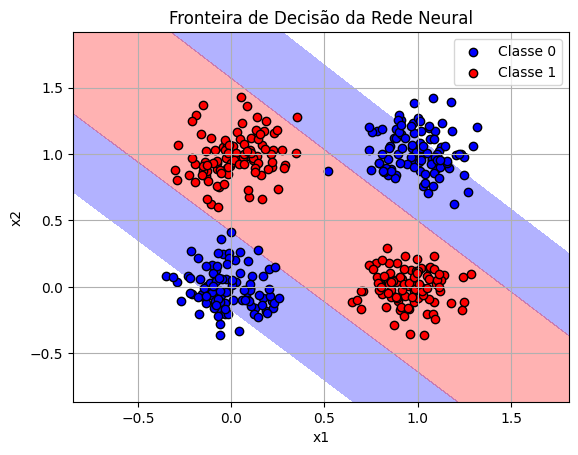

In [18]:
#Plot da fronteira de decisão
def plot_decision_boundary(net, X, y):
    # Define os limites do gráfico
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Prepara os pontos para a predição
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    # Obtém as predições da rede para cada ponto na grade
    Z = np.array([net.feedforward(point.reshape(-1, 1)) for point in grid_points])
    Z = Z.reshape(xx.shape)
    
    # Plota a fronteira de decisão
    plt.contourf(xx, yy, Z, levels=[-0.1, 0.5, 1.1], alpha=0.3, colors=['blue', 'red'])
    
    # Plota os pontos de dados originais
    plt.scatter(X[y.flatten() == 0, 0], X[y.flatten() == 0, 1], label='Classe 0', c='blue', edgecolor='k')
    plt.scatter(X[y.flatten() == 1, 0], X[y.flatten() == 1, 1], label='Classe 1', c='red', edgecolor='k')
    
    plt.title('Fronteira de Decisão da Rede Neural')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_decision_boundary(nn, X_train, y_train)

### Discussão

Os resultados mostram que a rede conseguiu aprender muito bem o problema proposto. A acurácia de 98.00%
% no treino indica que o modelo praticamente não cometeu erros nos dados usados para o ajuste, e a acurácia de 97.00% no teste confirma que ele também generalizou de forma satisfatória para dados novos.

A arquitetura escolhida, com três neurônios na camada escondida usando a tangente hiperbólica e um neurônio de saída linear, foi suficiente para capturar a relação não linear entre as variáveis. Isso permitiu que a rede criasse regiões de decisão bem definidas, separando quase todos os pontos de forma correta.

Em resumo, a rede foi capaz de transformar os dados em um espaço onde a separação se tornou simples, mostrando boa capacidade de classificação e consistência entre treino e teste.

### Dados Breast Cancer

In [19]:
#Breast Cancer Dataset
import pandas as pd
#Importa o dataset ignorando a coluna com a numeracao das linhas
data = pd.read_csv("DataSets//Breast_Cancer.csv",index_col=0)


In [20]:
#Embaralha os dados para evitar qualquer viés na ordem dos dados
data = data.sample(frac=1).reset_index(drop=True)

# Rotular as classes maligna e benigna como 0 e 1 respectivamente
data['Class'] = data['Class'].map({'malignant': 0, 'benign': 1})

#Eliminar dados faltantes
data = data.dropna()

In [21]:
#Separar o conjunto de dados em treinamento e teste respeitando a proporcao dos labels

#Treino 70% teste 30%
#Processo de ajkuste deve ser repetido 10 vezes para garantir a robustez do modelo
from sklearn.model_selection import train_test_split
x = data.drop(['Id', 'Class'],axis=1).values
y = data['Class'].values.reshape(-1, 1)

x = x.reshape(-1,9,1)

In [22]:
# Loop de 10 iterações para robustez
#Aramzenaremos erros de cada iteracao pra calculo da média e desvio padrão
errors = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)
    nn = NeuralNetwork([9, 5, 1])
    nn.train(X_train, y_train, epochs=35, eta=0.05,print_cost=False)
    
    #Calcula percentual de amostras classificadas incorretamente
    num_errors = 0
    for x_sample, y_true in zip(X_test, y_test):
        x_sample = x_sample
        raw_prediction = nn.feedforward(x_sample)
        predicted_class = 1 if raw_prediction > 0.5 else 0
        if predicted_class != y_true[0]:
            num_errors += 1
    
    errors.append((num_errors / len(y_test)) * 100)

#Calcula a média e o desvio padrão dos erros
mean_error = np.mean(errors)
std_error = np.std(errors)
print(f"Vetor de erros (%) {errors}")
print(f"Erro médio: {mean_error:.2f}%, Desvio padrão: {std_error:.2f}%")

Vetor de erros (%) [1.951219512195122, 4.878048780487805, 4.390243902439024, 1.951219512195122, 5.853658536585367, 4.878048780487805, 5.853658536585367, 3.414634146341464, 3.902439024390244, 3.414634146341464]
Erro médio: 4.05%, Desvio padrão: 1.33%


### Discussão

O processo de amostragem utilizou a divisão 30% para teste e 70% para treino, garantindo o balanceamento entre as classes. Essa etapa foi repetida 10 vezes para aumentar a robustez da análise e evitar que os resultados dependessem de uma única partição dos dados.

Os valores encontrados mostram que a rede conseguiu manter estabilidade e baixo nível de erro, mesmo em diferentes divisões do conjunto. O desvio padrão relativamente pequeno confirma que não houve grande variação entre as execuções, reforçando a confiabilidade do modelo.

Em síntese, a RNA se mostrou eficaz para o problema, apresentando desempenho consistente e com boa capacidade de generalização, o que indica que a arquitetura utilizada foi adequada para capturar os padrões relevantes do conjunto de dados.